In [1]:
import pickle
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile, expandvars

# data
zenith = 'random' # 'z20'  
table = 'regressor_5sgm_xy_flip.pickle'
path = f'{expandvars("$HOME")}/E4/irf_{zenith}/crab/'
dataset = join(path, table)

# dataset 
if '.pickle' in table:
    with open(dataset,'rb') as f: ds = pickle.load(f)
    infotable = join(path, table.replace('.pickle', '.dat'))
elif '.npy' in table:
    ds = np.load(dataset, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
    infotable = join(path, table.replace('.npy', '.dat'))

if '_CLEAN' in infotable:
    infotable = infotable.replace('_CLEAN', '')
    
print(f"Maps: {ds.keys()}")
print(f"DS dataset size: {len(ds['DS'])}")

Maps: dict_keys(['DS', 'LABELS'])
DS dataset size: 20000


In [2]:
from astroai.tools.utils import split_regression_dataset

binning = 200
train_data, train_labels, test_data, test_labels = split_regression_dataset(ds, split=80, reshape=True, binning=binning)

print(f"Train dataset: {len(train_data)}, {train_data.shape}")
print(f"Train labels: {len(train_labels)}, {train_labels.shape}")
print(f"\nTest dataset: {len(test_data)}, {test_data.shape}")
print(f"Test labels: {len(test_labels)}, {test_labels.shape}")

(16000, 200, 200) (16000, 2)
Train dataset: 16000, (16000, 200, 200, 1)
Train labels: 16000, (16000, 2)

Test dataset: 4000, (4000, 200, 200, 1)
Test labels: 4000, (4000, 2)


# Load model and weights

In [3]:
import tensorflow as tf

# model
cnn = 'regressor_zALL'

model = tf.keras.models.load_model(f'../models/crta_models/{cnn}.keras')
model.summary()

2024-09-05 15:18:01.061197: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-05 15:18:10.340644: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-05 15:18:10.340688: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-09-05 15:18:21.059648: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 197, 197, 6)       102       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 12)        300       
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 12)        588       
                                                                 
 conv2d_3 (Conv2D)           (None, 95, 95, 12)        588       
                                                                 
 conv2d_4 (Conv2D)           (None, 94, 94, 12)        588       
                                                        

In [4]:
%time
predictions = model.predict(test_data) * binning

CPU times: user 5 µs, sys: 10 µs, total: 15 µs
Wall time: 30 µs
125/125 [==============================] - 8s 56ms/step


In [5]:
import numpy as np
from astroai.tools.utils import plot_heatmap, set_wcs

# get random seed
idx = np.random.choice(range(len(test_data)))
# find seed to get the original heatmap
seed = len(train_data) + idx + 1

# get simulation data
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
row = infodata[infodata['seed']==seed]
row

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
24362,crab_19363,19363,0,100,100,1.252138,20.481565,0.009549,21.02912,1.284491,North_z60_N_0.5h_LST,2.5,6.561644


In [6]:
predictions[idx], test_labels[idx] * binning

(array([47.642746, 74.89719 ], dtype=float32),
 array([52.46179932, 77.30399211]))

In [7]:
from astroai.tools.utils import *

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)

# TRUE
true_sky = SkyCoord(ra=row['source_ra'].values[0], dec=row['source_dec'].values[0], unit='deg', frame='icrs')
x, y = w.world_to_pixel(true_sky) 
true_sky = true_sky.ra.deg, true_sky.dec.deg
true_pix = x, y

# LABEL
label_pix = test_labels[idx][0] * binning, test_labels[idx][1] * binning
sky = w.pixel_to_world(label_pix[0], label_pix[1])
label_sky = sky.ra.deg, sky.dec.deg

# PREDICTION
pred_pix = predictions[idx]
sky = w.pixel_to_world(pred_pix[0], pred_pix[1])
pred_sky = sky.ra.deg, sky.dec.deg


print(f'SEED: {seed}')
print('---- PIX')
print(f"true: {true_pix}")
print(f"label: {label_pix}")
print(f"prediction: {pred_pix}")
print('---- SKY')
print(f"true: {true_sky} ")
print(f"label: {label_sky}")
print(f"prediction: {pred_sky}")

SEED: 19363
---- PIX
true: (array(52.46179932), array(77.30399211))
label: (52.461799315032955, 77.30399211483507)
prediction: [47.642746 74.89719 ]
---- SKY
true: (1.2521384871605878, 20.48156530029948) 
label: (1.252138487160579, 20.481565300299483)
prediction: (1.3801828463354298, 20.42041135766772)


In [8]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025
figsize = (10, 10)
histsize = (8, 8)
fs = 16
sz = 1.5e3

# LEGENDS
custom_lines = [Line2D([0], [0], color='k', lw=1, ls='-.'),
                Line2D([0], [0], color='r', lw=1, ls='-'),
                Line2D([0], [0], color='w', lw=1, ls='--')]

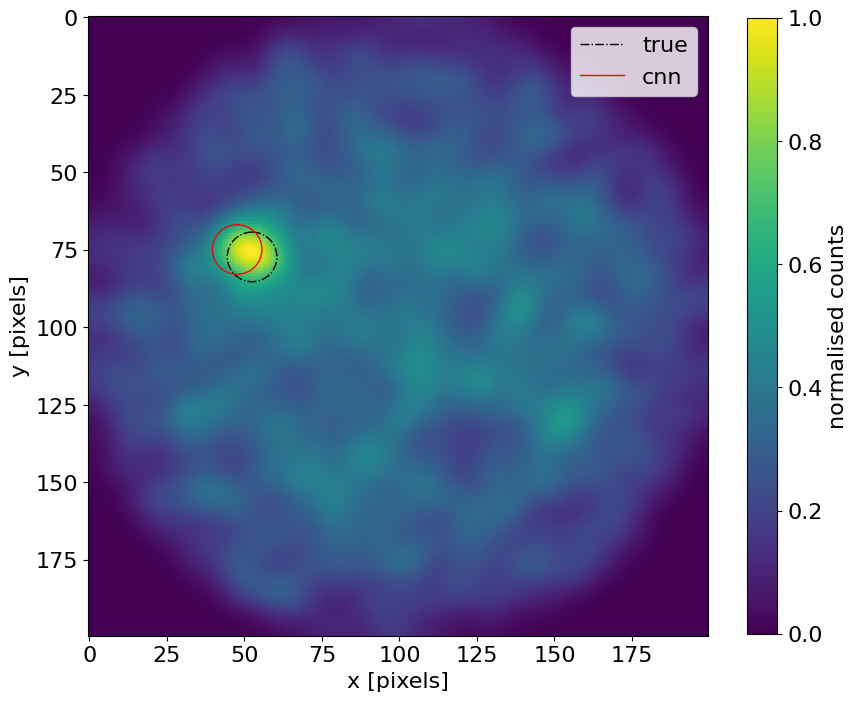

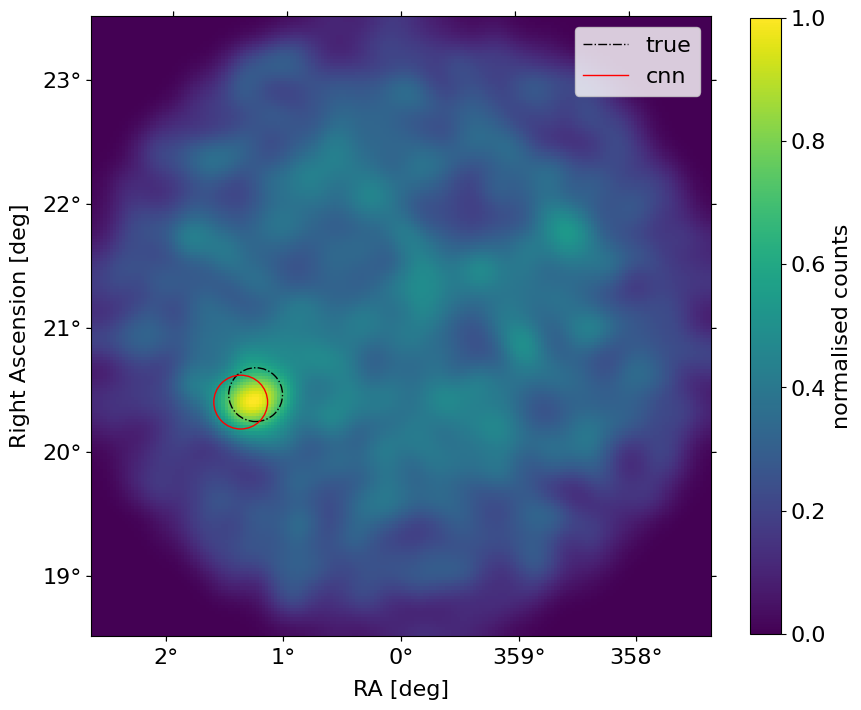

In [9]:
# PIX
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

img = ax.imshow(test_data[idx], vmin=0, vmax=1)
ax.add_patch(plt.Circle((true_pix), radius=radius_pix, edgecolor='k', facecolor='none', ls='-.'))
ax.add_patch(plt.Circle((pred_pix), radius=radius_pix, edgecolor='r', facecolor='none', ls='-'))
ax.set_ylabel('y [pixels]', fontsize=fs)
ax.set_xlabel('x [pixels]', fontsize=fs)
#ax.set_title(f'counts map coordinates {seed}', fontsize=fs)
ax.legend(custom_lines[:2], ['true', 'cnn'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/regressor_{seed}_pix.png')
plt.show()

# SKY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)

img = ax.imshow(test_data[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.scatter(true_sky[0], true_sky[1], transform=ax.get_transform('icrs'), s=sz,
           edgecolor='k', facecolor='none', ls='-.')
ax.scatter(pred_sky[0], pred_sky[1], transform=ax.get_transform('icrs'), s=sz,
           edgecolor='r', facecolor='none', ls='-')
ax.set_ylabel('Right Ascension [deg]', fontsize=fs)
ax.set_xlabel('RA [deg]', fontsize=fs)
#ax.set_title(f'counts map {seed}', fontsize=fs)
ax.legend(custom_lines[:2], ['true', 'cnn'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/regressor_{seed}_sky.png')
plt.show()

plt.show()

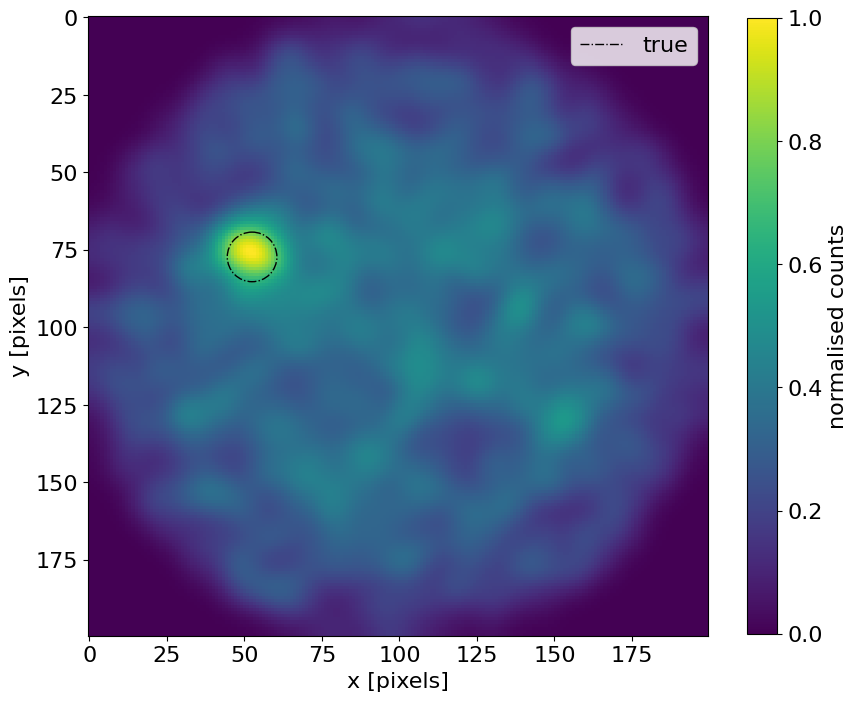

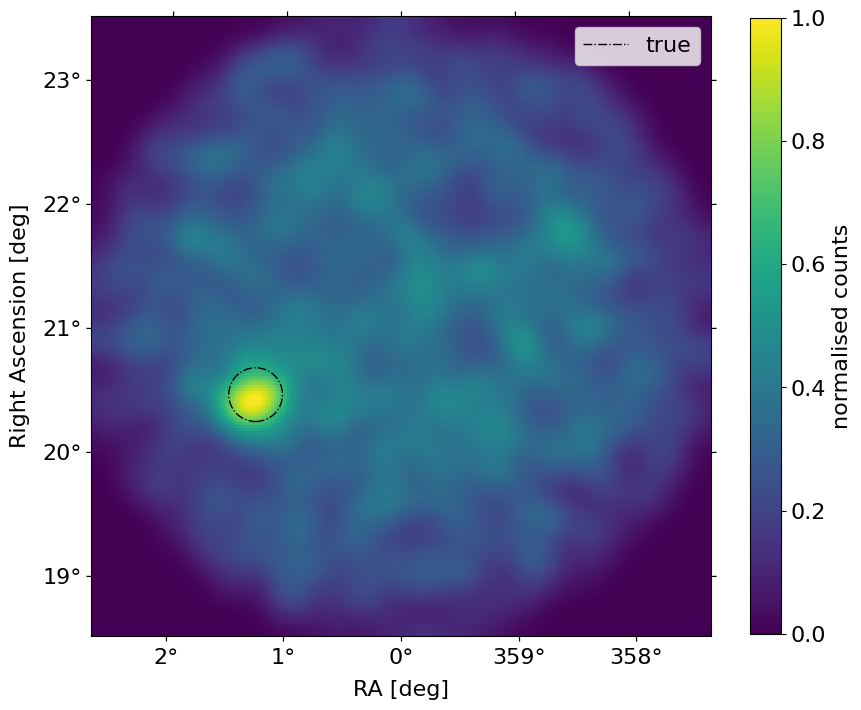

In [10]:
# PIX
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

img = ax.imshow(test_data[idx], vmin=0, vmax=1)
ax.add_patch(plt.Circle((true_pix), radius=radius_pix, edgecolor='k', facecolor='none', ls='-.'))
ax.set_ylabel('y [pixels]', fontsize=fs)
ax.set_xlabel('x [pixels]', fontsize=fs)
#ax.set_title(f'counts map coordinates {seed}', fontsize=fs)
ax.legend(custom_lines[:1], ['true'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/regressor_{seed}_pix_true.png')
plt.show()

# SKY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)

img = ax.imshow(test_data[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.scatter(true_sky[0], true_sky[1], transform=ax.get_transform('icrs'), s=sz,
           edgecolor='k', facecolor='none', ls='-.')
ax.set_ylabel('Right Ascension [deg]', fontsize=fs)
ax.set_xlabel('RA [deg]', fontsize=fs)
#ax.set_title(f'counts map {seed}', fontsize=fs)
ax.legend(custom_lines[:1], ['true'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/regressor_{seed}_sky_true.png')
plt.show()

plt.show()

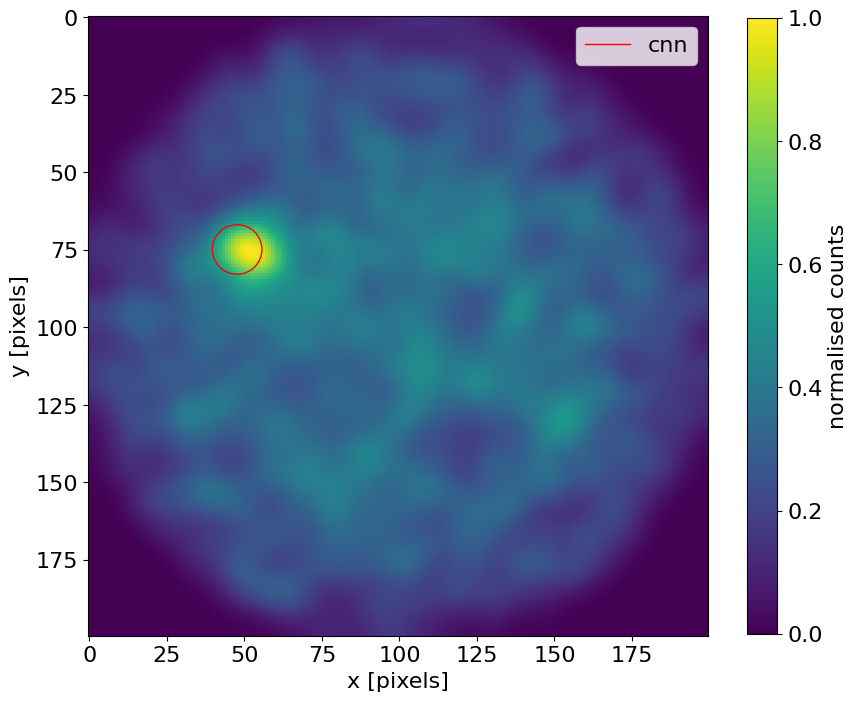

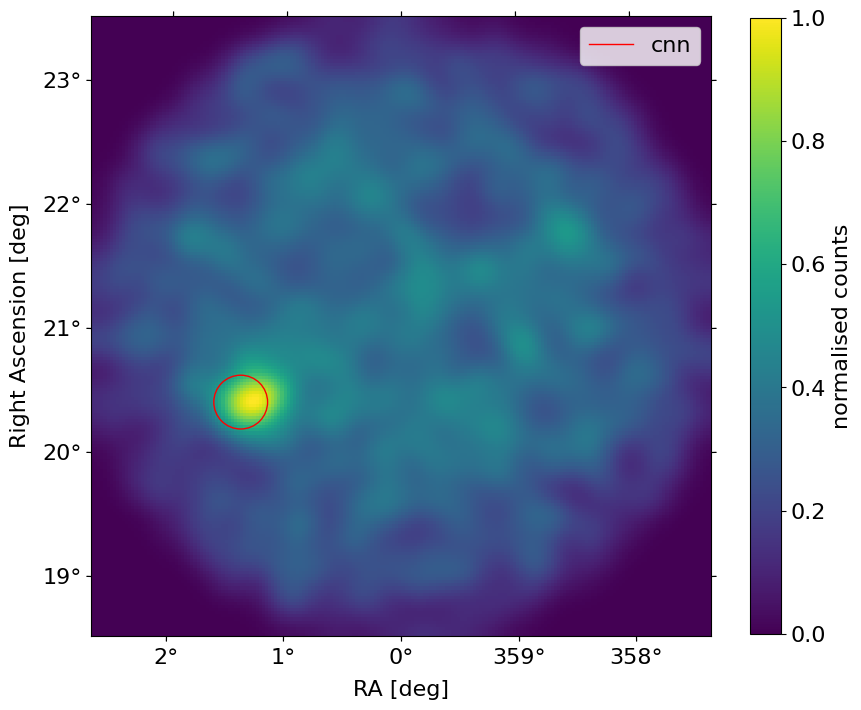

In [11]:
# PIX
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

img = ax.imshow(test_data[idx], vmin=0, vmax=1)
ax.add_patch(plt.Circle((pred_pix), radius=radius_pix, edgecolor='r', facecolor='none', ls='-'))
ax.set_ylabel('y [pixels]', fontsize=fs)
ax.set_xlabel('x [pixels]', fontsize=fs)
#ax.set_title(f'counts map coordinates {seed}', fontsize=fs)
ax.legend(custom_lines[1:], ['cnn'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/regressor_{seed}_pix_pred.png')
plt.show()

# SKY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)

img = ax.imshow(test_data[idx], vmin=0, vmax=1)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)
ax.scatter(pred_sky[0], pred_sky[1], transform=ax.get_transform('icrs'), s=sz,
           edgecolor='r', facecolor='none', ls='-')
ax.set_ylabel('Right Ascension [deg]', fontsize=fs)
ax.set_xlabel('RA [deg]', fontsize=fs)
#ax.set_title(f'counts map {seed}', fontsize=fs)
ax.legend(custom_lines[1:], ['cnn'], fontsize=fs)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

fig.savefig(f'img/regressor_{seed}_sky_pred.png')
plt.show()

plt.show()

# Plot loss

In [12]:
loss = model.evaluate(test_data, test_labels, verbose=2)

125/125 - 7s - loss: 0.0167 - accuracy: 0.9570 - 7s/epoch - 59ms/step


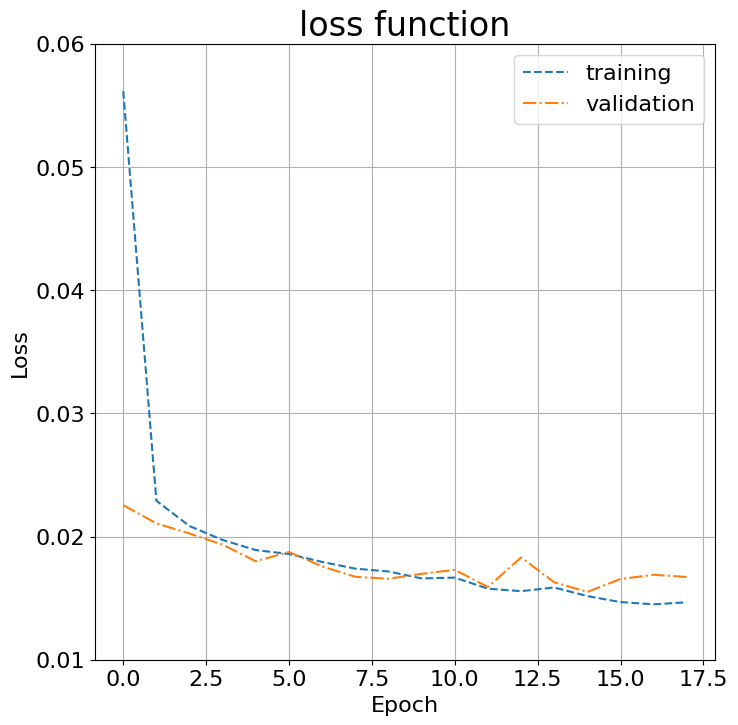

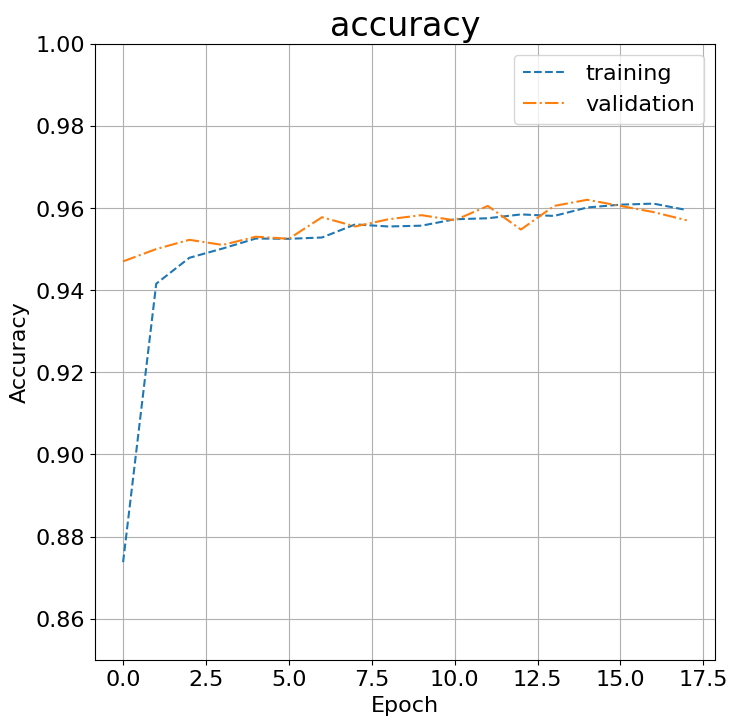

In [14]:
import matplotlib.pyplot as plt

history = np.load(f'../models/crta_models/{cnn}_history.npy', 
                  allow_pickle='TRUE').item()

# LOSS
fig, ax = plt.subplots(figsize=histsize)
ax.tick_params(axis='both', labelsize=fs)
ax.plot(history['loss'], ls='--', label='training')
ax.plot(history['val_loss'], ls='-.', label = 'validation')
ax.set_xlabel('Epoch', fontsize=fs)
ax.set_ylabel('Loss', fontsize=fs)
ax.set_title('loss function', fontsize=fs*1.5)
ax.set_ylim([0.01,0.06])
ax.grid()
ax.legend(fontsize=fs)

plt.show()
fig.savefig(f'img/regressor_loss_FINAL.png')

# ACCURACY
fig, ax = plt.subplots(figsize=histsize)
ax.tick_params(axis='both', labelsize=fs)
ax.plot(history['accuracy'], ls='--', label='training')
ax.plot(history['val_accuracy'], ls='-.', label = 'validation')
ax.set_xlabel('Epoch', fontsize=fs)
ax.set_ylabel('Accuracy', fontsize=fs)
ax.set_title('accuracy', fontsize=fs*1.5)
ax.set_ylim([0.85,1])
ax.grid()
ax.legend(fontsize=fs)

plt.show()
fig.savefig(f'img/regressor_accuracy_FINAL.png')

# Get separation error

In [15]:
from astroai.tools.utils import *
from astropy.coordinates import SkyCoord

# get true coordinates in SkyCoord
true = SkyCoord(ra=row['source_ra'].values[0], dec=row['source_dec'].values[0], unit='deg', frame='icrs')

# get errors
err = true.separation(sky)

print(f"TRUE: ({true.ra.deg}, {true.dec.deg})\n")
print(f"PREDICTION: ({sky.ra.deg}, {sky.dec.deg})\n")
print(f"ERROR: {err.deg}")

TRUE: (1.2521384871605878, 20.48156530029948)

PREDICTION: (1.3801828463354298, 20.42041135766772)

ERROR: 0.13466083282233696


# Get DS separation error

In [16]:
err = []
s = len(train_data)
for pred, label in zip(predictions, test_labels):
    s += 1 
    row = infodata[infodata['seed']==s]
    # WCS coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
                point_ref=point_ref, pixelsize=pixelsize)
    # simulated coordinates
    true_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    true_pix = {'x': label[0], 'y': label[1]}
    # prediction coordinates
    sky = w.pixel_to_world(pred[0], pred[1])
    found_deg = {'ra': sky.ra.deg, 'dec': sky.dec.deg}
    # find separation in data
    true_sky = SkyCoord(ra=true_deg['ra'], dec=true_deg['dec'], unit='deg', frame='icrs')
    found_sky = SkyCoord(ra=found_deg['ra'], dec=found_deg['dec'], unit='deg', frame='icrs')
    err.append(true_sky.separation(found_sky))

err_noisy = [e.degree for e in err]
len(err_noisy)

4000

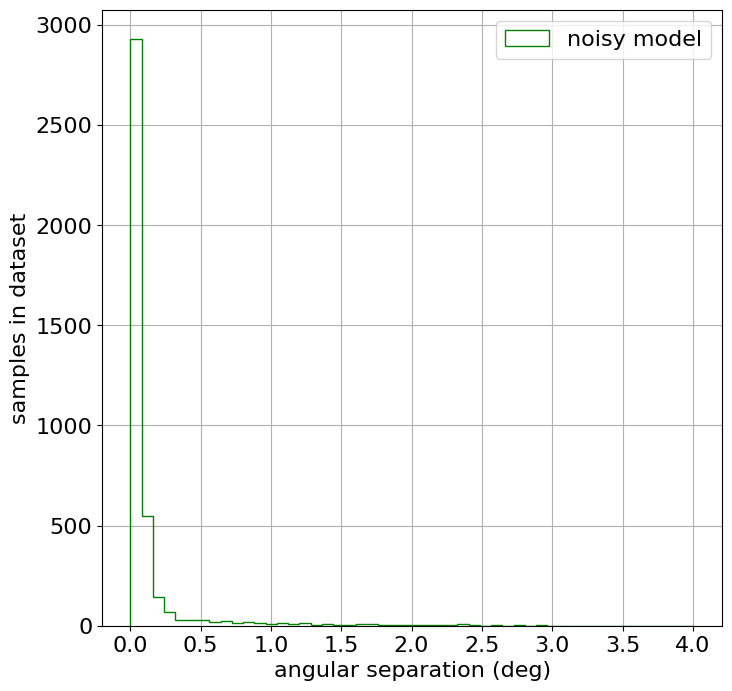

In [17]:
fig, ax = plt.subplots(figsize=histsize)
ax.tick_params(axis='both', labelsize=fs)

# cumulative counts hist
data = err_noisy
#ax.set_title('reconstruction error', fontsize=fs*1.5)
ax.hist(data, 50, density=False, histtype='step', color='g', label=['noisy model'])
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('angular separation (deg)', fontsize=fs)
ax.grid()
ax.legend(fontsize=fs)

plt.show()
fig.savefig(f'img/regressor_loc_error_noisy.png')

## Statistical measures

2024-09-05 15:21:45.657 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted halflogistic distribution with error=57.843503)
2024-09-05 15:21:45.658 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=34.265702)
2024-09-05 15:21:45.659 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted halfnorm distribution with error=113.907946)
2024-09-05 15:21:45.661 | WARNING  | fitter.fitter:_fit_single_distribution:337 - SKIPPED _fit distribution (taking more than 30 seconds)
2024-09-05 15:21:45.662 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gumbel_l distribution with error=160.287609)
2024-09-05 15:21:45.664 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gumbel_r distribution with error=71.96868)
2024-09-05 15:21:45.665 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted halfcauchy distribution with error=7.658406)
2024-09-05 15:21:45.682 | INFO     | fitter.fitter:_fit_singl

2024-09-05 15:21:46.068 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted trapezoid distribution with error=181.056563)
2024-09-05 15:21:46.068 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted kstwobign distribution with error=112.722412)
2024-09-05 15:21:46.093 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rice distribution with error=126.132861)
2024-09-05 15:21:46.093 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted wrapcauchy distribution with error=92.803133)
2024-09-05 15:21:46.109 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted truncexpon distribution with error=165.481559)
2024-09-05 15:21:46.116 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rel_breitwigner distribution with error=11.686093)
2024-09-05 15:21:46.132 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted genexpon distribution with error=34.273289)
2024-09-05 15:21:46.149 | INFO     | fitter.fitter:_fit_

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
loglaplace,0.288542,1024.431548,1043.313697,inf,0.040173,4.790683e-06
foldcauchy,1.548499,933.332810,952.214959,inf,0.066251,1.042274e-15
gibrat,5.521808,1443.437256,1456.025355,inf,0.085917,3.876125e-26
fisk,5.680286,1123.208263,1142.090412,inf,0.042971,7.429096e-07
kappa3,6.115685,1037.112170,1055.994318,inf,0.108369,2.305018e-41


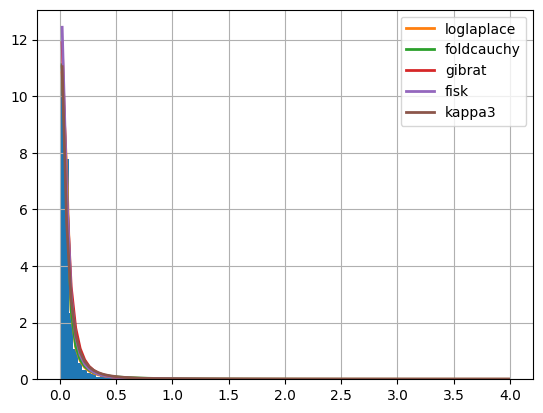

In [18]:
from fitter import Fitter, get_common_distributions

f = Fitter(err_noisy) # this will fit every distribution available
#distributions = ['foldcauchy', 'gibrat', 'halfcauchy', 'kappa3', 'lognorm'] # these 5 are the best fitting 
#f = Fitter(err_noisy, distributions)
f.fit()
f.summary()

In [19]:
f.fitted_param['lognorm']

(1.1484752896617578, 0.00014672782970845838, 0.05393549591856419)

In [20]:
mu = f.fitted_param['lognorm'][-1]
mu

0.05393549591856419

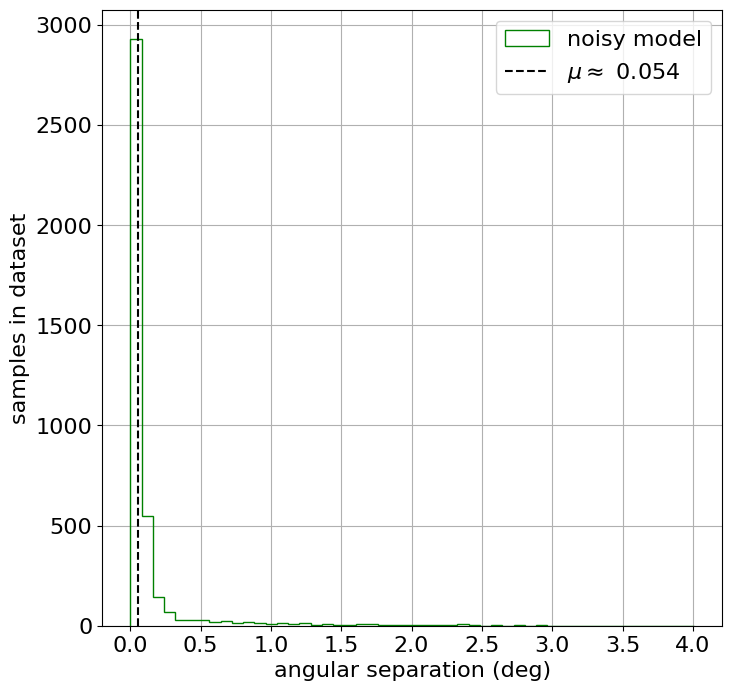

In [21]:
fig, ax = plt.subplots(figsize=histsize)
ax.tick_params(axis='both', labelsize=fs)

# cumulative counts hist
data = err_noisy
#ax.set_title('reconstruction error', fontsize=fs*1.5)
ax.hist(data, 50, density=False, histtype='step', color='g', label=['noisy model'])
ax.axvline(mu, c='k', ls='--', label=fr'$\mu \approx$ {np.round(mu, 3)}')
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('angular separation (deg)', fontsize=fs)
ax.grid()
ax.legend(fontsize=fs)

plt.show()
fig.savefig(f'img/regressor_loc_error_noisy.png')

# Gammapy comparison

In [28]:
gammafile = infotable.replace('.dat', '_gammapy.txt')
gammadata = pd.read_csv(gammafile, sep=' ', header=0).sort_values(by=['seed'])
gammadata.head()


,seed,loc_ra,loc_dec
0,1,57.267818,30.441771
1,2,98.165826,40.944170
2,3,76.894712,-66.343824
3,4,125.480814,-44.467154
4,5,214.105104,42.757503


In [29]:
err = []
seeds = gammadata['seed']
for i, seed in enumerate(seeds):
    row = infodata[infodata['seed']==seed]
    grow = gammadata[gammadata['seed']==seed]
    # WCS coordinates
    w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
                point_ref=point_ref, pixelsize=pixelsize)
    # simulated coordinates
    true_deg = {'ra': row['source_ra'].values[0], 'dec': row['source_dec'].values[0]}
    # found coordinates
    found_deg = {'ra': grow['loc_ra'].values[0], 'dec': grow['loc_dec'].values[0]}
    # find separation in data
    true_sky = SkyCoord(ra=true_deg['ra'], dec=true_deg['dec'], unit='deg', frame='icrs')
    found_sky = SkyCoord(ra=found_deg['ra'], dec=found_deg['dec'], unit='deg', frame='icrs')
    err.append(true_sky.separation(found_sky))
    
err_gamma = [e.degree for e in err]
len(err_noisy), len(err_gamma)

(4000, 100)

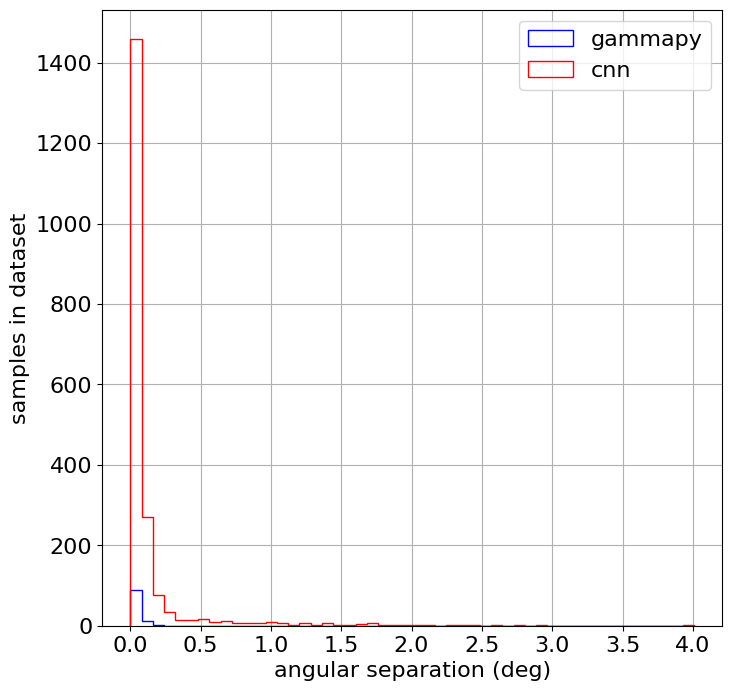

In [30]:
data = (err_noisy[2000:], err_gamma)

colors = ['red', 'blue']

fig, ax = plt.subplots(figsize=histsize)
ax.tick_params(axis='both', labelsize=fs)

# cumulative counts hist
#ax.set_title('localisation error', fontsize=fs*1.5)
ax.hist(data, 50, density=False, histtype='step', color=colors, label=['cnn', 'gammapy'])
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('angular separation (deg)', fontsize=fs)
ax.grid()
ax.legend(fontsize=fs)

plt.show()
fig.savefig(f'img/regressor_loc_error_cnn_vs_gp.png')

In [ ]:
data = (err_noisy[2000:], err_gamma)

colors = ['red', 'blue']

fig, ax = plt.subplots(figsize=histsize)
ax.tick_params(axis='both', labelsize=fs)

# cumulative counts hist
#ax.set_title('localisation error', fontsize=fs*1.5)
ax.hist(data, 50, density=False, histtype='step', color=colors, label=['cnn', 'gammapy'])
ax.axvline(mu, c='r', ls='--', label=fr'$\mu \approx$ {np.round(mu, 3)}')
ax.axvline(mu_gamma, c='b', ls=':', label=fr'$\mu \approx$ {np.round(mu_gamma, 3)}')
ax.set_ylabel('samples in dataset', fontsize=fs)
ax.set_xlabel('angular separation (deg)', fontsize=fs)
ax.grid()
ax.legend(fontsize=fs)

plt.show()
fig.savefig(f'img/regressor_loc_error_cnn_vs_gp.png')

In [ ]:
with open(f'data/loc_cnn_{zenith}.pickle', 'wb') as f: pickle.dump(err_noisy, f, protocol=4)
with open(f'data/loc_gammapy_{zenith}.pickle', 'wb') as f: pickle.dump(err_gamma, f, protocol=4)

/scratch/homes/dipiano/venvs/astroai/lib64/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
